In [66]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from plotly import graph_objects as go 
import plotly

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [2]:
creditfraud = pd.read_csv('creditcard.csv')
#creditfraud.drop(['Time'],axis=1,inplace=True)

In [18]:
fraud = creditfraud[creditfraud['Class'] == 1]
clean = creditfraud[creditfraud['Class'] == 0].sample(100000)
data = pd.concat([fraud,clean],axis=0)

In [133]:
tsne = TSNE(learning_rate=50,random_state=42)
tsne_3D = TSNE(learning_rate=50,random_state=42,n_components=3,perplexity=10)

def fit_tsne(predictors):
    """Fits t-sne to predictors
        returns <np.array>
    """
    #X = StandardScaler().fit_transform(predictors)
    #return tsne.fit_transform(X)
    return tsne.fit_transform(predictors)

def fit_tsne_3d(predictors):
    """Fits t-sne to predictors
        returns <np.array>
    """
    #X = StandardScaler().fit_transform(predictors)
    #return tsne.fit_transform(X)
    return tsne_3D.fit_transform(predictors)

def resample(n):
    """n samples of clean + all fraud
        returns : predictors <np.array>, targets <np.array>
    """
    fraud = creditfraud[creditfraud['Class'] == 1]
    clean = creditfraud[creditfraud['Class'] == 0].sample(n)
    data = pd.concat([fraud,clean],axis=0) 
    X = data.iloc[:,0:-1].values
    targets = data.iloc[:,-1].values
    return X,targets

def tsne_plot(tsne_fit,labels, title = None, f_name = None):
    """Plots 2D t-sne"""
    fraud = tsne_fit[labels == 1]
    clean = tsne_fit[labels == 0]
    plt.figure(figsize = (10,10))

    plt.scatter(fraud[:,0],fraud[:,1],
    color = 'red',alpha=0.2,label='fraud')

    plt.scatter(clean[:,0],clean[:,1], 
    color = 'blue',alpha=0.2,label='normal')
    if title is not None:
        plt.title(title,fontsize = 10)
    plt.legend()

    if f_name is not None:
        plt.savefig('graphs/'+f_name+'.png')

def plotly_3d(data, color_labels):
    """
    Creates interactive plotly 3D scatter plot
    data:= <N x 3, np.array>
    """
    cols = []
    for i in range(color_labels.size):
        if color_labels[i] == 0:
            cols.append('blue')
        else:
            cols.append('red')

    plotly.offline.init_notebook_mode()
    trace = go.Scatter3d(
        x=data[:,0],  # <-- Put your data instead
        y=data[:,1],  # <-- Put your data instead
        z=data[:,2],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 4,
            'opacity': 0.8,
            'color': cols
        }
    )
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
    )
    points = [trace]
    plot_figure = go.Figure(data=points, layout=layout)
    plotly.offline.iplot(plot_figure)

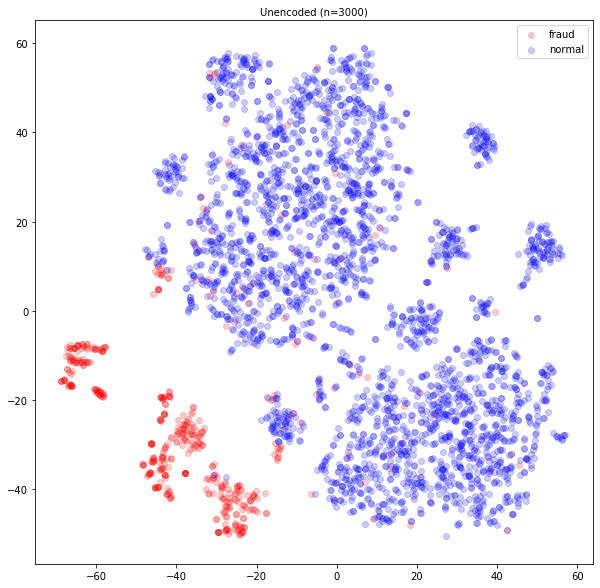

In [134]:
#t-sne plot test
pred, targ = resample(3000)
tsne_fit = fit_tsne(MinMaxScaler().fit_transform(pred))
tsne_plot(tsne_fit,targ, f_name='Unencoded3000',title='Unencoded (n=3000)')



In [110]:
normal_X = MinMaxScaler().fit_transform(clean.iloc[:,0:-1].values)

inputs = Input(shape=(normal_X.shape[1],))
encode = Dense(150, activation='tanh',
    activity_regularizer=regularizers.l2(1e-5))(inputs)
encode = Dense(100, activation = 'relu')(encode)
encode = Dense(50, activation = 'relu')(encode)


decode = Dense(50, activation = 'tanh')(encode)
decode = Dense(100, activation = 'tanh')(decode)
decode = Dense(150, activation = 'tanh')(decode)
outputs = Dense(normal_X.shape[1], activation='relu')(decode)

NN = Model(inputs, outputs)
NN.compile(optimizer="adam", loss="mse")


NN.fit(normal_X, normal_X, batch_size = 2048, epochs = 100, shuffle = True, validation_split=0.20)

Epoch 1/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0788 - val_loss: 0.0520
Epoch 2/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0439 - val_loss: 0.0424
Epoch 3/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0423 - val_loss: 0.0421
Epoch 4/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0420 - val_loss: 0.0418
Epoch 5/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 6/100
40/40 [==============================] - 1s 13ms/step - loss: 0.0408 - val_loss: 0.0355
Epoch 7/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0337 - val_loss: 0.0331
Epoch 8/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0331 - val_loss: 0.0330
Epoch 9/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0329 - val_loss: 0.0329
Epoch 10/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0328 - val_loss: 0.0328

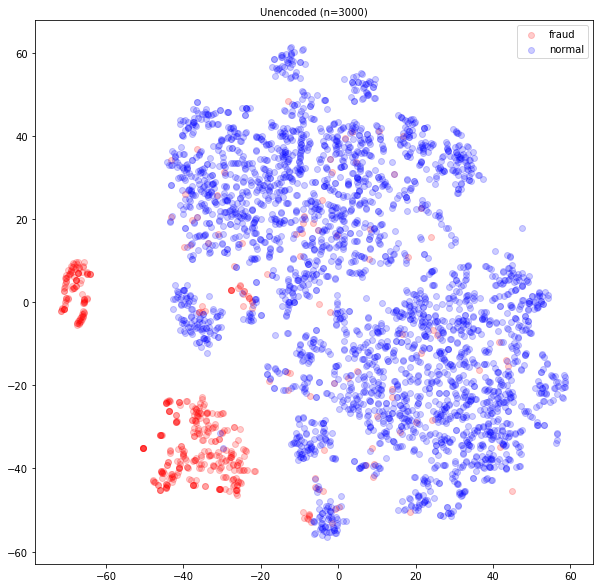

In [135]:

encodeNN = Sequential()
encodeNN.add(NN.layers[0])
encodeNN.add(NN.layers[1])
encodeNN.add(NN.layers[2])
encodeNN.add(NN.layers[3])

#resamp, labels = resample(2000)
#resamp = MinMaxScaler().fit_transform(resamp)
encoded = encodeNN.predict(MinMaxScaler().fit_transform(pred))
encoded_tsne = fit_tsne(encoded)
tsne_plot(encoded_tsne,targ,f_name='Encoded3000',title='Unencoded (n=3000)')


In [56]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

0.9622792937399679

In [136]:
#without encoder
clf = SVC()

clf.fit(pred,targ)
no_enc = clf.score(pred,targ)


clf.fit(encoded_tsne,targ)
enc = clf.score(encoded_tsne,targ)

print("no encoder: {}, encoder: {}".format(no_enc,enc))

no encoder: 0.8591065292096219, encoder: 0.9687857961053837
